## Reinforcement Learning 2: *Markov Decision Processes (MDPs)*

*Note:* Given that the basic notions about MDPs we have covered so far are still very theoretical, we will primarily
cover examples of how to formulate a problem as an MDP. Example 3 will then demonstrate very simple potential
solutions. This is just to complement the content of the lectures and textbook, but this week's practicals will not be about solution methods, but rather the concepts behind formalizing learning problems as MDPs and simulating the MDP.

## 1. The Casinos environment

In this example, we are going to construct and study the environment for the Casinos scenario presented in [this article](https://medium.com/@alejandro.aristizabal24/understanding-reinforcement-learning-hands-on-markov-decision-processes-7d8469a8a782). This simple example demonstrates how to implement an MDP and how to interface with the OpenAI-gym.

The Casinos environment is a simple scenario which presents two states, representing two distinct casinos. In each of the casinos, there are multiple slot machines that can be played, resulting in variable rewards (this behavior is very much related to the [multi-armed bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit)). Note that those actions will not change the agent's current state. To allow transitions between the two casinos, an additional action is added to both states, called **Take a bus**. This action is non-deterministic, which means that with some probability, the agent moves from one state/casino to the other or stays in the same. Here's a full diagram of the MDP describing this problem:

<img src='https://drive.google.com/uc?id=1vBWxvCO_6V125zNHz2MSVa75a7pjbhIq'></img>

We're going to be using the OpenAI-gym to construct our custom environment. We will be going step-by-step, and each step will add some detail to the MDP.

**Reference:**
- Aristizabal, A. (2020, October 19). Understanding Reinforcement Learning Hands-On: Markov Decision Processes. Medium. [https://towardsdatascience.com/understanding-reinforcement-learning-hands-on-markov-decision-processes-7d8469a8a782](https://towardsdatascience.com/understanding-reinforcement-learning-hands-on-markov-decision-processes-7d8469a8a782)

**a**) Create a custom environment, adapting the Gym template

Below, you will find the backbone of a gym environment. This has all the necessary functions to create an acceptable environment. We will start adding details to this template in order to construct our desired environment

In [24]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GridWorldEnv(gym.Env):
    """
    Casinos custom environment, built with the gym interface
    """
    metadata= {'render.modes': ['human']}

    def __init__(self):
        super(GridWorldEnv, self).__init__()
        # Here, we declare our initial configuration
        # Usually, this includes defining the action
        # and observation step
        pass

    def step(self, action):
        # This function executes a one-step simulation
        # in our environment. Receives the desired action
        # the agent has taken as input
        pass

    def reset(self):
        # Restarts the environment to a starting position.
        # Usually, changes in the environment will be undone,
        # and the environment is reseeded
        pass

    def render(self, mode='human'):
        # Display the environment in some way. The mode defines
        # in which way we desire to display it.
        pass

We will now go through each individual function or method. Before we do so, there are some special remarks to do about the template:

- It inherits from the `gym.Env` class
    - Our class contains a global property called `metadata`. This parameter usually contains information meant for the developer. Most of the time, it includes a list of all possible ways the developer is able to render the specific environment. In this case, only `'human'` is allowed.

1. Initialization

The initialization is where we add any primary configurations required for the environment to work properly. Most of the time, we only need to define two required properties of the environment: the `action_space` and `observation_space` (or `state_space`). Both of these values define the number of actions the agent may find, as well as what it should expect to receive from the state of the environment. As a sidenote, we use the name "observation" here because sometimes, the whole state of the environment isn't accessible to the agent. In our case, observation and state will be the same thing, which means that an agent interacting with the environment will have full access to the state.

In [25]:
class GridWorldEnv(gym.Env):
    """
    Casinos custom environment, built with the gym interface
    """
    metadata= {'render.modes': ['human']}

    def __init__(self):
        super(GridWorldEnv, self).__init__()
        # Here, we declare our initial configuration
        # Usually, this includes defining the action
        # and observation step
        self.observation_space = spaces.Discrete(2)
        self.action_space = spaces.Tuple((spaces.Discrete(3), spaces.Discrete(4)))
        self.agent_pos = np.random.randint(2)

Inside the initialization method, we have declared both necessary properties. There are many options offered by gym to define how our observation and action space looks like. Most of the time, we can find out what option to choose from the problem at hand.

Our environment contains two distinct states (Casino 1, Casino 2). They are discrete, and so we use the `spaces.Discrete(2)` option. For our actions, the MDP described previously had a different set of actions according to which casino we find ourselves in. In each casino, we also have a discrete number of actions we can take. For the first casino we only have three actions, while for the second we have 4. For this reason, we used a `spaces.Tuple`, which contains two sets of discrete spaces, one for each state.

Lastly, we added an additional variable, which stores the agent's current position. This allows the environment to keep track of the agent's state, and it is also what the agent will see from any observation.

2. Step

Our step function contains most of the interaction dynamics of the environment. This is the function our agent calls
everytime it wants to take an action upon the environment. Because of this, the step function is in charge of evaluating such action, and transitioning to the corresponding state. It also defines how much reward the agent should receive, the next observation that the agent will use to take future actions, and whether the agent reached an ending state.

We have all the necessary information with the diagram above, so we will turn it into code here.

In [26]:
class GridWorldEnv(gym.Env):
    """
    Casinos custom environment, built with the gym interface
    """
    metadata= {'render.modes': ['human']}

    def _next_observation(self):
        return {'state': self.agent_pos}

    def step(self, action):
        """
        Our actions will be defined as:
        - Casino 1 (state 0):
            - Action 0: Pull Arm 0, go to state 0, get reward 0.5
            - Action 1: Pull Arm 1, go to state 0, get reward -1
            - Action 2: Take a bus,
                70% of times: go to state 1, get reward -2
                30% of times: go to state 0, get reward -0.5

        - Casino 2 (state 1):
            - Action 0: Pull Arm 0, go to state 1, get reward -2
            - Action 1: Pull Arm 1, go to state 1, get reward 1.2
            - Action 2: Pull Arm 2, go to state 1, get reward -1.5
            - Action 3: Take a bus,
                80% of times: go to state 0, get reward -2
                30% of times: go to state 1, get reward -0.5

        Returns:
            observation (object): agent's observation of the current environment
            reward (float) : amount of reward returned after previous action
            done (bool): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """

        # dictionary of functions that return [reward, next_state] transitions for each action
        state_0_transitions = {
            0: lambda: [0.5, 0],
            1: lambda: [-1, 0],
            2: lambda: [[-2, 1],[-0.5, 0]][np.random.choice(2,p=[0.7,0.3])]
        }

        state_1_transitions = {
            0: lambda: [-2, 1],
            1: lambda: [1.2, 1],
            2: lambda: [-1.5, 1],
            3: lambda: [[-2, 0],[-0.5, 1]][np.random.choice(2,p=[0.8,0.2])]
        }

        reward = None
        next_state = None
        if (self.agent_pos==0):
            # Agent is at Casino 1. Use state 0 transitions
            reward, next_state = state_0_transitions[action]()
        else:
            # Agent is at Casino 2. Use state 1 transitions
            reward, next_state = state_1_transitions[action]()

        # Transition the agent to the next state
        self.agent_pos = next_state
        # Return the data as defined by the gym interface
        return self._next_observation(), reward, False, {}

So, in the `step` method, we defined some objects that display how the environment reacts to the agent's actions. Then, depending on the current state the agent is found, the agent responds and generates the `next_state` and `reward`. This method thus specifies the **dynamics** of the MDP, i.e. $p(s', r | s, a)$. Lastly, we return the information the way the gym interface expects us to do. We also defined another function, called `_next_observation`. It's a pretty basic function, that was added mainly to keep our observations consistent.

Other remarks about what we return:
- the `done` variable is always set to False, since our environment doesn't have any termination state.
- the `info` variable is always empty. We do not need to add any auxiliary information with our environment.

3. Reset

Our reset function will be pretty simple. The only thing we need to reset is the agent's position. Our reset function needs to return an observation, so we're reusing the `_next_observation` function declared above

In [27]:
class GridWorldEnv(gym.Env):
    """
    Casinos custom environment, built with the gym interface
    """
    metadata= {'render.modes': ['human']}

    def reset(self):
        # Reset the agent's position
        self.agent_pos = np.random.randint(2)
        return self._next_observation()

4. Render

Inside the render function we define how we want to visualize the environment. The gym interface offers a list of modes that people might expect to find in an environment. It is up to us to define how our environment displays, and which modes it supports. The `metadata` global property inside our environment's class contains a list of supported modes, which in our case only contains `human`. The `human` mode means that whatever we render is intended for a human to visualize. We will simply print the agent's current state.

In [28]:
class GridWorldEnv(gym.Env):
    """
    Casinos custom environment, built with the gym interface
    """
    metadata= {'render.modes': ['human']}

    def render(self, mode='human'):
        if mode == 'human':
            pretty_print_state = {
                0: "Casino 1",
                1: "Casino 2"
            }
            print('Current State: {}'.format(pretty_print_state[self.agent_pos]))
        else:
            raise NotImplementedError()

5. Putting it all together

Now that we have specified all required methods, let's create the full MDP:

In [29]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GridWorldEnv(gym.Env):
    """
    Casinos custom environment, built with the gym interface
    """
    metadata= {'render.modes': ['human']}

    def __init__(self):
        super(GridWorldEnv, self).__init__()

        self.observation_space = spaces.Discrete(2)
        self.action_space = spaces.Tuple((spaces.Discrete(3), spaces.Discrete(4)))
        self.agent_pos = np.random.randint(2)

    def _next_observation(self):
        return {'state': self.agent_pos}

    def step(self, action):
        # dictionary of functions that return [reward, next_state] transitions for each action
        state_0_transitions = {
            0: lambda: [0.5, 0],
            1: lambda: [-1, 0],
            2: lambda: [[-2, 1],[-0.5, 0]][np.random.choice(2,p=[0.7,0.3])]
        }

        state_1_transitions = {
            0: lambda: [-2, 1],
            1: lambda: [1.2, 1],
            2: lambda: [-1.5, 1],
            3: lambda: [[-2, 0],[-0.5, 1]][np.random.choice(2,p=[0.8,0.2])]
        }

        reward = None
        next_state = None
        if (self.agent_pos==0):
            # Agent is at Casino 1. Use state 0 transitions
            reward, next_state = state_0_transitions[action]()
        else:
            # Agent is at Casino 2. Use state 1 transitions
            reward, next_state = state_1_transitions[action]()

        # Transition the agent to the next state
        self.agent_pos = next_state
        # Return the data as defined by the gym interface
        return self._next_observation(), reward, False, {}

    def reset(self):
        # Reset the agent's position
        self.agent_pos = np.random.randint(2)
        return self._next_observation()

    def render(self, mode='human'):
        if mode == 'human':
            pretty_print_state = {
                0: "Casino 1",
                1: "Casino 2"
            }
            print('Current State: {}'.format(pretty_print_state[self.agent_pos]))
        else:
            raise NotImplementedError()

That's it! Our MDP is now fully implemented, and we can interact with it! Let's make a pretty simple agent and do some simulations with it. Our agent will simply take random actions and print which action it took, as well as the reward received:

In [30]:
env = GridWorldEnv()
curr_state = env.agent_pos
steps = 100

pretty_print_a_0 = {
    0: "Arm 1",
    1: "Arm 2",
    2: "Take a bus",
}

pretty_print_a_1 = {
    0: "Arm 1",
    1: "Arm 2",
    2: "Arm 3",
    3: "Take a bus",
}

for _ in range(steps):
    env.render()
    action = env.action_space[curr_state].sample() # Sample an action from the current state
    print_a = None
    if curr_state==0:
        print_a = pretty_print_a_0[action]
    else:
        print_a = pretty_print_a_1[action]
    print("Action taken: {}".format(print_a))
    obs, reward, _, _ = env.step(action) # Execute a step, get observation and reward
    curr_state = obs['state']
    print("Reward obtained: {}".format(reward))
    print("===========================")

Current State: Casino 1
Action taken: Take a bus
Reward obtained: -2
Current State: Casino 2
Action taken: Arm 1
Reward obtained: -2
Current State: Casino 2
Action taken: Arm 1
Reward obtained: -2
Current State: Casino 2
Action taken: Take a bus
Reward obtained: -2
Current State: Casino 1
Action taken: Take a bus
Reward obtained: -0.5
Current State: Casino 1
Action taken: Arm 1
Reward obtained: 0.5
Current State: Casino 1
Action taken: Take a bus
Reward obtained: -2
Current State: Casino 2
Action taken: Arm 3
Reward obtained: -1.5
Current State: Casino 2
Action taken: Take a bus
Reward obtained: -2
Current State: Casino 1
Action taken: Arm 1
Reward obtained: 0.5
Current State: Casino 1
Action taken: Arm 1
Reward obtained: 0.5
Current State: Casino 1
Action taken: Arm 2
Reward obtained: -1
Current State: Casino 1
Action taken: Arm 2
Reward obtained: -1
Current State: Casino 1
Action taken: Arm 1
Reward obtained: 0.5
Current State: Casino 1
Action taken: Arm 1
Reward obtained: 0.5
Curren

---
## 2. Real-world examples

To better understand the scope and applicability of MDPs to formalize certain types of problems, let's some at some real-world examples. These examples are adapted from the reference below so, for more information, check out the full article.

**Reference:**
- Banerjee, S. (2021, January 18). Real World Applications Of Markov Decision Process (MDP). Medium.
[https://towardsdatascience.com/real-world-applications-of-markov-decision-process-mdp-a39685546026](https://towardsdatascience.com/real-world-applications-of-markov-decision-process-mdp-a39685546026)

#### 2.1. Salmon fishing

A fisherman has to decide what proportion of salmons to catch in a year in a specific area to maximize his long-term return.
Each salmon generates a fixed revenue. But if a large proportion of salmons are caught then next year's yield will be lower. We need to find the optimum portion of salmons to catch to (sustainably) maximize the return over a long time period.

Let's consider a simplified version of the problem: whether to fish a certain portion of salmon or not. This problem can be expressed as an MDP as follows:
- States: The number of salmons available in that area in that year. For simplicity, assume there are only four states: $\mathcal{S}=\{\texttt{empty}, \texttt{low}, \texttt{medium}, \texttt{high}\}$, with fixed thresholds (t1, t2)
- Actions: let's assume there are only two actions: $\mathcal{A}=\{\texttt{fish}, \texttt{not_to_fish}\}$.
- Rewards: Fishing at certain state generates rewards, let’s assume the rewards of fishing at state `low`, `medium`
and `high` are 5K, 50K and 100k respectively. If an action takes us to the empty state then the reward is very low -
200K as it requires re-breeding new salmons which takes time and money.
- State Transitions: From any state, the probability of moving to a state with a lower number of salmons is always
higher than the other way around. Similarly, the action `not_to_fish` has a higher probability of moving to a state with a higher number of salmons (except if we are already in the state high).
Let's depict this simplified salmon fishing MDP:

  ![](https://miro.medium.com/max/1400/1*6q1Lyrm7VRkBJitaUIc0DA.png)

Large circles are state nodes, small solid black circles are action nodes. Once an action is taken the environment responds with a reward and transitions to the next state. Such state transitions are represented by arrows from the action node to the state nodes. Each arrow shows the `<transition probability, reward>`. For example, from the state `Medium` action node `Fish` has 2 arrows transitioning to 2 different states: i) `Low` with (probability=0.75, reward=10K) or ii) back to `Medium` with (probability=0.25, reward=10K). In the state `Empty`, the only action is Re-breed which transitions to the state Low with (probability=1, reward=-200K).

---

#### 2.2. Quiz game show

In a quiz game show there are 10 levels, at each level one question is asked and, if answered correctly, a certain monetary reward based on the current level is given. The higher the level, the tougher the question, but the higher the reward.
At each round of play, if the participant answers the quiz correctly then (s)he wins the reward and also gets to decide whether to play at the next level or quit. If (s)he quits, then the participant gets to keep all the rewards earned so far. At any round, if the participant fails to answer correctly then (s)he looses “all” the rewards earned so far. The game stops at level 10. The goal is to decide on the actions to play or quit maximizing total rewards.
- States: $\mathcal{S}=\{\texttt{level1}, \texttt{level2}, \dots, \texttt{level10}\}$
- Actions: $\mathcal{A}=\{\texttt{Play}, \texttt{Quit}\}$
- Rewards: Play at level1, level2, …, level10 generates rewards 10, 50, 100, 500, 1000, 5000, 10000,
50000, 100000, 500000 with probability p = 0.99, 0.9, 0.8, …, 0.2, 0.1 respectively. The probability here is the probability of giving correct answer in that level. At any level, the participant loses with probability (1-p) and loses all the rewards earned so far.
Let's depict this quiz game MDP
    ![](https://miro.medium.com/max/1400/1*bwp3ycL0T9TruqyhSAEQEw.png)
We can see that, for the action play, there are two possible transitions: i) `won` which transitions to next level with probability p and the reward amount of the current level ii) `lost` which ends the game with probability (1-p) and loses all the rewards earned so far. Action `quit` ends the game with probability 1 and no rewards.
---


#### 2.3. Traffic lights

We want to decide the duration of traffic lights in an intersection maximizing the number cars passing the intersection without stopping. For simplicity, let'ss assume it is only a 2-way intersection, i.e. traffic can flow only in 2 directions: `north` or `east`; and the traffic light has only two colors `red` and `green`. Also assume the system has access to the number of cars approaching the intersection through sensors or just some estimates.
Say each time step of the MDP represents few (d=3 or 5) seconds. At each time step, we need to decide whether to change the traffic light or not.
- States: A state here is represented as a combination of
    - The color of the traffic light (red, green) in each directions
    - Duration of the traffic light in the same color
    - The number of cars approaching the intersection in each direction.
    So, each state is given by a triple $\mathcal{S}=\{ (\texttt{color}_{i}, \texttt{duration}_{i}, \texttt{#cars}_{i}) \}$
- Actions: Whether or not to change the traffic light: $\mathcal{A}=\{ \texttt{change}, \texttt{don't_change} \}$
- Rewards: Number of cars passing the intersection in the next time step minus some sort of discount for the traffic blocked in the other direction. The discount should exponentially grow with the duration of traffic being blocked. Note that the duration is captured as part of the current state and therefore the Markov property is still preserved.
Reward = (number of cars expected to pass in the next time step) — α * exp( β * duration of the traffic light red in the other direction)
- State Transitions: Transitions are deterministic. Action either changes the traffic light color or not. For either of the actions it changes to a new state as shown in the transition diagram below.

![](https://miro.medium.com/max/1072/1*doLo0FxsvNrVx2MmWOPdLg.png)

---

#### 2.4. Hospital admissions

A hospital has a certain number of beds. It receives a random number of patients everyday and needs to decide how many patients it can admit. Also, everyday a certain portion of patients in the hospital recovers and is released. The hospital would like to maximize the number of people recovered over a long period of time.
- States: The number of available beds, assuming the hospital has 100 beds $\mathcal{S}=\{1, 2, …, 100\}$
- Actions: Each day the hospital gets requests of number of patients to admit based on a Poisson random variable. The action is the number of patients to admit. Therefore the action is a number between 0 to (100 — s) where s is the current state i.e. the number of beds occupied. The action needs to be less than the number of requests the hospital has received that day. So, $\mathcal{A} = \{0, \texttt{min}(100 — s, \texttt{number of requests})\}$.
- Rewards: The reward is the number of patient recovered on that day which is a function of the number of patients in the current state. We can treat this as a Poisson distribution with mean s.
![](https://miro.medium.com/max/1092/1*w0j0kzAoy8mXriBfsqPtlg.png)


---
## 3. Grid world

Imagine an agent navigating a 2D, discrete environment (a grid). The cells of the grid, depicted below, correspond to the states of the environment. At each cell, 4 actions are possible: `north`, `south`, `east` and `west`. These actions move the agent in the corresponding direction. There are 2 special states `A` and `B`, from which any action always pushes the agent to states `A'` and `B'`, respectively. This special transition also results in larger rewards (+10 and +5, respectively). Actions that would take the agent off the grid have no effect (the agent remains in the same position) and result in a reward of -1. Other actions result in 0 reward.
<img alt="Grid world MDP" height="300" src="https://drive.google.com/uc?id=1Wx6ALilXFkkRG5scC4r8h0U--qffgt9s" title="Grid World" width="500"/>

**References:**
- Sutton & Barto, Ch.3, p.60 (example 3.5)

In [31]:
grid_size = 5
A_pos = [0, 1]
A_prime_pos = [4, 1]
B_pos = [0, 3]
B_prime_pos = [2, 3]
discount = 0.9

# left, up, right, down
ACTIONS = [np.array([0, -1]),
           np.array([-1, 0]),
           np.array([0, 1]),
           np.array([1, 0])]
ACTIONS_REP = [ '←', '↑', '→', '↓']

**a**) Define the Grid World's MDP dynamics: $p(s',r|s,a)$

In [32]:
def step(state, action, A, B, A_prime, B_prime):
    # special states
    if state == A:
        return A_prime, 10
    if state == B:
        return B_prime, 5

    # other states
    next_state = (np.array(state) + action).tolist()
    x, y = next_state
    # boundary states
    if x < 0 or x >= grid_size or y < 0 or y >= grid_size:
        reward = -1.0
        next_state = state
    # all others
    else:
        reward = 0
    return next_state, reward

**b**) Suppose the agent selects all four actions with equal probability in all states, i.e. the agent assumes a random uniform policy. Represent the state-value function $v(s)$ associated with this policy, assuming a discounting factor $\gamma = 0.9$.

**Note:** This and the following exercises depict methods to compute state-value functions by value iteration and the direct solution of the linear Bellman equations. Value iteration methods will be covered in detail next week, but the exercise is used here to demonstrate the application of the Bellman equations in a concrete case.

In [33]:
def value_iteration(grid_size, action_space, action_probability):
    value = np.zeros((grid_size, grid_size))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(grid_size):
            for j in range(grid_size):
                for action in action_space:
                    (next_i, next_j), reward = step([i, j], action)
                    # Bellman expectation equation
                    new_value[i, j] += action_probability * (reward + discount * value[next_i, next_j])
        if np.sum(np.abs(value - new_value)) < 1e-4: # cut-off (clip max_iterations or when the value change is too small)
            return new_value
            break
        value = new_value

In [34]:
def value_function(grid_size, action_space, action_probability, discount):
    # alternatively, we can solve the linear Bellman equation to find the exact solution
    P = -1 * np.eye(grid_size * grid_size)
    R = np.zeros(grid_size * grid_size)
    for i in range(grid_size):
        for j in range(grid_size):
            s = [i, j]  # current state
            index_s = np.ravel_multi_index(s, (grid_size, grid_size))
            for a in action_space:
                s_, r = step(s, a)
                index_s_ = np.ravel_multi_index(s_, (grid_size, grid_size))

                P[index_s, index_s_] += action_probability * discount
                R[index_s] -= action_probability * r
    x = np.linalg.solve(P, R)
    return x

In [35]:
# to simplify things, let's wrap all the MDP in a class
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table


# ###################################################################
# Specific MDPs
class GridWorld:
    # example 1 in MDPs
    def __init__(self, grid_size, posA, posA_prime, posB, posB_prime, actions, action_representations=None):
        self.grid_size = grid_size
        self.A = posA
        self.A_prime = posA_prime
        self.B = posB
        self.B_prime = posB_prime
        self.action_space = actions
        self.action_representations = action_representations
        # self.discount = discount

    def step(self, state, action, rw_scale=1.):
        # special states
        if state == self.A:
            return self.A_prime, rw_scale*10
        if state == self.B:
            return self.B_prime, rw_scale*5

        # others
        next_state = (np.array(state) + action).tolist()
        x, y = next_state
        # boundaries
        if x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size:
            reward = -1.0
            next_state = state
        # all other
        else:
            reward = 0
        return next_state, rw_scale*reward

    def value_function(self, action_probability, discount):
        A = -1 * np.eye(self.grid_size * self.grid_size)
        b = np.zeros(self.grid_size * self.grid_size)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                s = [i, j]  # current state
                index_s = np.ravel_multi_index(s, (self.grid_size, self.grid_size))
                for a in self.action_space:
                    s_, r = self.step(s, a)
                    index_s_ = np.ravel_multi_index(s_, (self.grid_size, self.grid_size))
                    A[index_s, index_s_] += action_probability * discount
                    b[index_s] -= action_probability * r
        x = np.linalg.solve(A, b)
        return x

    def value_iteration(self, action_probability, discount, rw_scale=1.):
        """
        Calculate the state-value function, using the Bellman equation
        """
        value = np.zeros((self.grid_size, self.grid_size))
        while True:
            # keep iteration until convergence
            new_value = np.zeros_like(value)
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    for action in self.action_space:
                        (next_i, next_j), reward = self.step([i, j], action, rw_scale)
                        # Bellman expectation equation
                        new_value[i, j] += action_probability * (reward + discount * value[next_i, next_j])
            if np.sum(np.abs(value - new_value)) < 1e-4: # cut-off (clip max_iterations or when the value change is too small)
                return new_value
            else:
                value = new_value

    def optimal_value_function(self, discount):
        value = np.zeros((self.grid_size, self.grid_size))
        while True:
            # keep iteration until convergence
            new_value = np.zeros_like(value)
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    values = []
                    for action in self.action_space:
                        (next_i, next_j), reward = self.step([i, j], action)
                        # value iteration
                        values.append(reward + discount * value[next_i, next_j])
                    new_value[i, j] = np.max(values) # !
            if np.sum(np.abs(new_value - value)) < 1e-4:
                return new_value
            value = new_value


    def draw(self, image):
        """
        Illustration for the tabular world example
        :param image:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = image.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(image):
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"
            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')

        # Row and column labels...
        for i in range(len(image)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')
        ax.add_table(tb)

    def draw_policy(self, optimal_values):
        """
        Represent the optimal policy on the grid
        :param values:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = optimal_values.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(optimal_values):
            next_vals=[]
            for action in self.action_space:
                next_state, _ = self.step([i, j], action)
                next_vals.append(optimal_values[next_state[0],next_state[1]])

            best_actions=np.where(next_vals == np.max(next_vals))[0]
            val=''
            for ba in best_actions:
                val+=self.action_representations[ba]
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"

            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')
        # Row and column labels...
        for i in range(len(optimal_values)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')

        ax.add_table(tb)

In [36]:
gw = GridWorld(grid_size, A_pos, A_prime_pos, B_pos, B_prime_pos, ACTIONS)

CPU times: user 50.4 ms, sys: 0 ns, total: 50.4 ms
Wall time: 50 ms


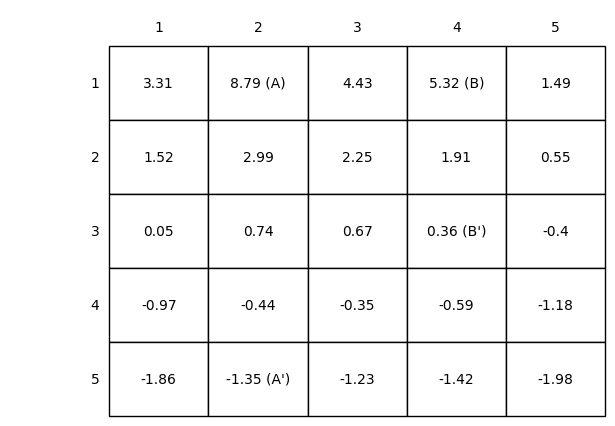

In [37]:
%%time
vf = gw.value_iteration(action_probability=0.25, discount=0.9)
gw.draw(np.round(vf.reshape(gw.grid_size, gw.grid_size), decimals=2))

CPU times: user 124 ms, sys: 321 ms, total: 446 ms
Wall time: 32.5 ms


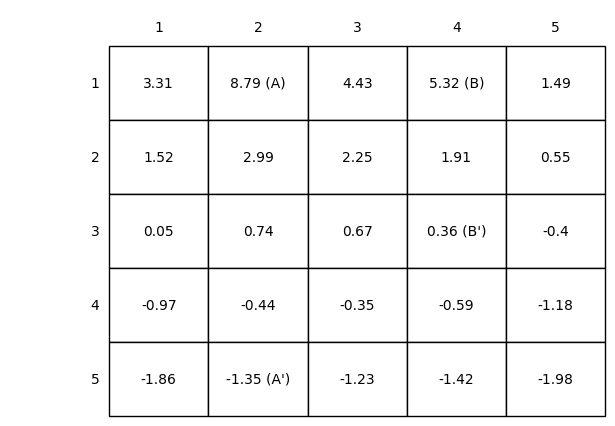

In [38]:
%%time
vf = gw.value_function(action_probability=0.25, discount=0.9)
gw.draw(np.round(vf.reshape(gw.grid_size, gw.grid_size), decimals=2))

**c**) Show numerically that the Bellman equation for the state value function ($v_{\pi}$) holds for the center state (3,3), valued at +0.67, with respect to its 4 neighboring states, valued at -0.35, +0.36, +2.25 and +0.74. 

Under the random policy, all actions are equiprobable ($\pi(a \mid s)=1/4, \forall a \in \mathcal{A}$), so the Bellman equation becomes the sum of the discounted value of all subsequent states:

$$v_{(3,3)} = \frac{1}{4} \times \left( \gamma v_{(2,3)} + \gamma v_{(3,4)} + \gamma v_{(4,3)} + \gamma v_{(3,2)} \right)$$

In [39]:
value_center = 1./4. * 0.9 * (-0.35 + 0.36 + 2.25 + 0.74)
print(value_center)

0.675


**d**) Repeat b) and c) for $\gamma = 0.3$.

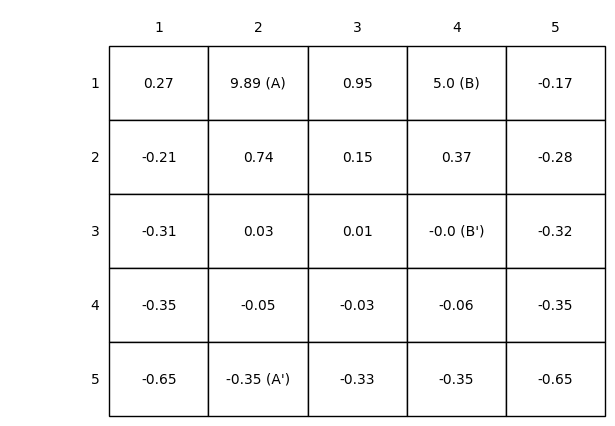

In [40]:
vf = gw.value_function(action_probability=0.25, discount=0.3)
gw.draw(np.round(vf.reshape(gw.grid_size, gw.grid_size), decimals=2))

In [41]:
value_center = 1./4. * 0.3 * (0.15 - 0. - 0.03 + 0.03)
print(value_center)

0.01125


**e**) Plot the value of states A and B as a function of $\gamma$

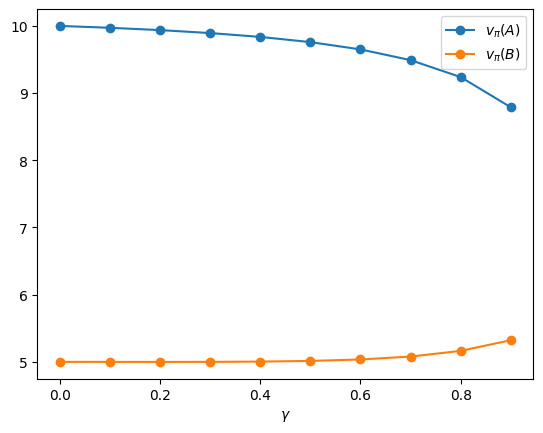

In [42]:
value_A = []
value_B = []
gamma = np.arange(0., 1., 0.1)
for disc in gamma:
    vf = gw.value_function(action_probability=0.25, discount=disc)
    value_A.append(vf[1])
    value_B.append(vf[3])
fig, ax = plt.subplots()
ax.plot(gamma, value_A, 'o-', label=r'$v_{\pi}(A)$')
ax.plot(gamma, value_B, 'o-', label=r'$v_{\pi}(B)$')
ax.set_xlabel(r'$\gamma$')
plt.legend()

**f**) Finally, let's find the optimal policy and value functions to navigate the grid world

In [43]:
def optimal_value_function(grid_size, action_space, discount):
    value = np.zeros((grid_size, grid_size))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(grid_size):
            for j in range(grid_size):
                values = []
                for action in action_space:
                    (next_i, next_j), reward = step([i, j], action)
                    # value iteration
                    values.append(reward + discount * value[next_i, next_j])
                new_value[i, j] = np.max(values) # !
        if np.sum(np.abs(new_value - value)) < 1e-4:
            return new_value
        else:
            value = new_value

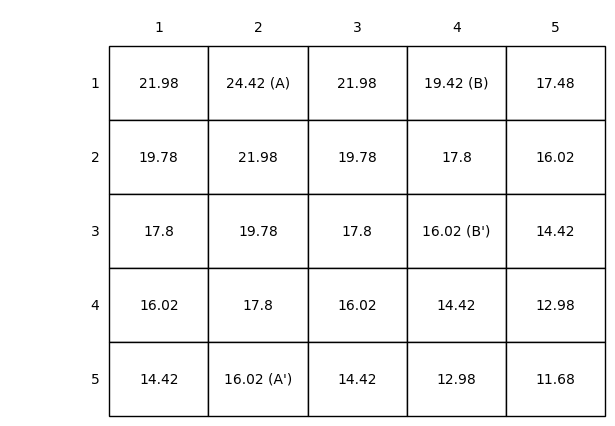

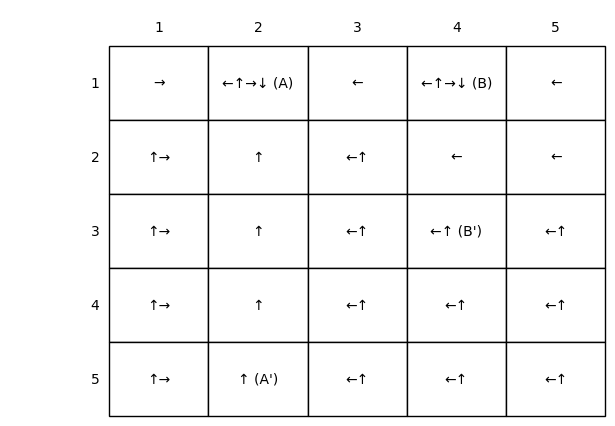

In [44]:
gw = GridWorld(grid_size, A_pos, A_prime_pos, B_pos, B_prime_pos, ACTIONS, ACTIONS_REP)
ovf = gw.optimal_value_function(discount=0.9)
gw.draw(np.round(ovf.reshape(gw.grid_size, gw.grid_size), decimals=2))
op = gw.draw_policy(ovf)

As an additional programming exercise, try to re-implement this GridWorld environment in `gym`. 

**Note**: This task is optional and purely for your further interest. You are not required to submit this exercise. 

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GridWorldEnv(gym.Env):
    """
    Casinos custom environment, built with the gym interface
    """
    metadata= {'render.modes': ['human']}

    

    def __init__(self):
        super(GridWorldEnv, self).__init__()
        # Here, we declare our initial configuration
        # Usually, this includes defining the action
        # and observation step
        
        self.observation_space = (spaces.Discrete(5), spaces.Discrete(5))
        self.action_space = (spaces.Discrete(4))
        self.agent_pos = (np.random.randint(1,5), np.random.randint(1,5))

        self.grid_size = 5
        self.A = [0, 1]
        self.A_prime = [4, 1]
        self.B = [0, 3]
        self.B_prime = [2, 3]
        self.discount = 0.9

        # left, up, right, down
        self.ACTIONS = [np.array([0, -1]),
                np.array([-1, 0]),
                np.array([0, 1]),
                np.array([1, 0])]
        self.ACTIONS_REP = [ '←', '↑', '→', '↓']

    def step(self, state, action):
        # special states
        if state == self.A:
            return self.A_prime, 10
        if state == self.B:
            return self.B_prime, 5

        # other states
        next_state = (np.array(state) + ACTIONS[action-1]).tolist()
        x, y = next_state
        # boundary states
        if x < 0 or x >= grid_size or y < 0 or y >= grid_size:
            reward = -1.0
            next_state = state
        # all others
        else:
            reward = 0
        return next_state, reward

    def reset(self):
        # Restarts the environment to a starting position.
        # Usually, changes in the environment will be undone,
        # and the environment is reseeded
        self.agent_pos = (np.random.randint(1,5), np.random.randint(1,5))
        return self.agent_pos

    def draw(self, image):
        """
        Illustration for the tabular world example
        :param image:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = image.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(image):
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"
            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')

        # Row and column labels...
        for i in range(len(image)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')
        ax.add_table(tb)

    def draw_policy(self, optimal_values):
        """
        Represent the optimal policy on the grid
        :param values:
        :return:
        """
        fig, ax = plt.subplots()
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])

        nrows, ncols = optimal_values.shape
        width, height = 1.0 / ncols, 1.0 / nrows

        # Add cells
        for (i, j), val in np.ndenumerate(optimal_values):
            next_vals=[]
            for action in self.action_space:
                next_state, _ = self.step([i, j], action)
                next_vals.append(optimal_values[next_state[0],next_state[1]])

            best_actions=np.where(next_vals == np.max(next_vals))[0]
            val=''
            for ba in best_actions:
                val+=self.action_representations[ba]
            # add state labels
            if [i, j] == self.A:
                val = str(val) + " (A)"
            if [i, j] == self.A_prime:
                val = str(val) + " (A')"
            if [i, j] == self.B:
                val = str(val) + " (B)"
            if [i, j] == self.B_prime:
                val = str(val) + " (B')"

            tb.add_cell(i, j, width, height, text=val,
                        loc='center', facecolor='white')
        # Row and column labels...
        for i in range(len(optimal_values)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                        edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                        edgecolor='none', facecolor='none')

        ax.add_table(tb)

    def render(self, mode='human'):
        # Display the environment in some way. The mode defines
        # in which way we desire to display it.
        pass

In [2]:



env = GridWorldEnv()

ovf = gw.optimal_value_function(discount=0.9)
env.draw(np.round(ovf.reshape(env.grid_size, env.grid_size), decimals=2))
#op = gw.draw_policy(ovf)

curr_state = env.agent_pos
steps = 20


for _ in range(steps):
    env.draw(np.round(ovf.reshape(env.grid_size, env.grid_size), decimals=2))
    action = env.action_space.sample() # Sample an action from the current state
    print_a = None
    if curr_state==0:
        print_a = pretty_print_a_0[action]
    else:
        print_a = pretty_print_a_1[action]
    print("Action taken: {}".format(print_a))
    obs, reward = env.step(curr_state ,action) # Execute a step, get observation and reward
    curr_state = obs
    print("Reward obtained: {}".format(reward))
    print("===========================")

NameError: name 'ovf' is not defined